In [1]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from re import sub
from adjustText import adjust_text

import plotnine
from plotnine import *


def flatten(t):
    return [item for sublist in t for item in sublist]

dpi = 300

In [2]:
case = 200
result_path='/lustre/scratch117/cellgen/team283/tl7/project/nanostring-covid/data/SpaceJam/LungAtlas_model/results/20220411_SpaceJam_UKCIC33Donor/'

if case == 100:
    # PRES and ACFF
    result_directory='LocationModelWTAMultiExperimentHierarchicalGeneLevel_26experiments_62clusters_141locations_10276genes_33DonorPRESEDADACFFgeneE-6_cellE6/'
    adata_vis=sc.read_h5ad(f"{result_path}{result_directory}sp.h5ad")

    # DADs and BRON
    result_directory='LocationModelWTAMultiExperimentHierarchicalGeneLevel_20experiments_62clusters_92locations_10276genes_33DonorNoPRESEDADACFFgeneE-6_cellE6/'

elif case == 200:
    result_directory='LocationModelWTAMultiExperimentHierarchicalGeneLevel_23experiments_62clusters_94locations_10276genes_PRESPRES-likeACFF_cell1e6/'
    adata_vis=sc.read_h5ad(f"{result_path}{result_directory}sp.h5ad")

    result_directory='LocationModelWTAMultiExperimentHierarchicalGeneLevel_28experiments_62clusters_139locations_10276genes_MDADODAD-likeODADBRON_cell1e6/'

adata_vis=adata_vis.concatenate(sc.read_h5ad(f"{result_path}{result_directory}sp.h5ad"))
adata_vis.obs['area mm2']=np.array(adata_vis.obs['area'] * 1e-6, dtype='float32')

### Figure 3A

In [3]:
cross = pd.crosstab(index=adata_vis.obs.Pathology, 
                             columns=adata_vis.obs.Donor_AltName,
                             margins=False)

In [4]:
cross=cross.stack().reset_index().rename(columns={ 0:'n_ROIs'})
cross=cross[[cross.iloc[c]['n_ROIs'] != 0 for c in range(len(cross)) ]]
cross=cross[[cross.iloc[c]['Pathology'] not in ['ACFF', 'BRON'] for c in range(len(cross)) ]]

cross["Donor_number"] = pd.to_numeric([sub(".*_", "", label) for label in cross.Donor_AltName.values])
cross = cross.sort_values(by = "Donor_number").drop(columns = ["Donor_number"])


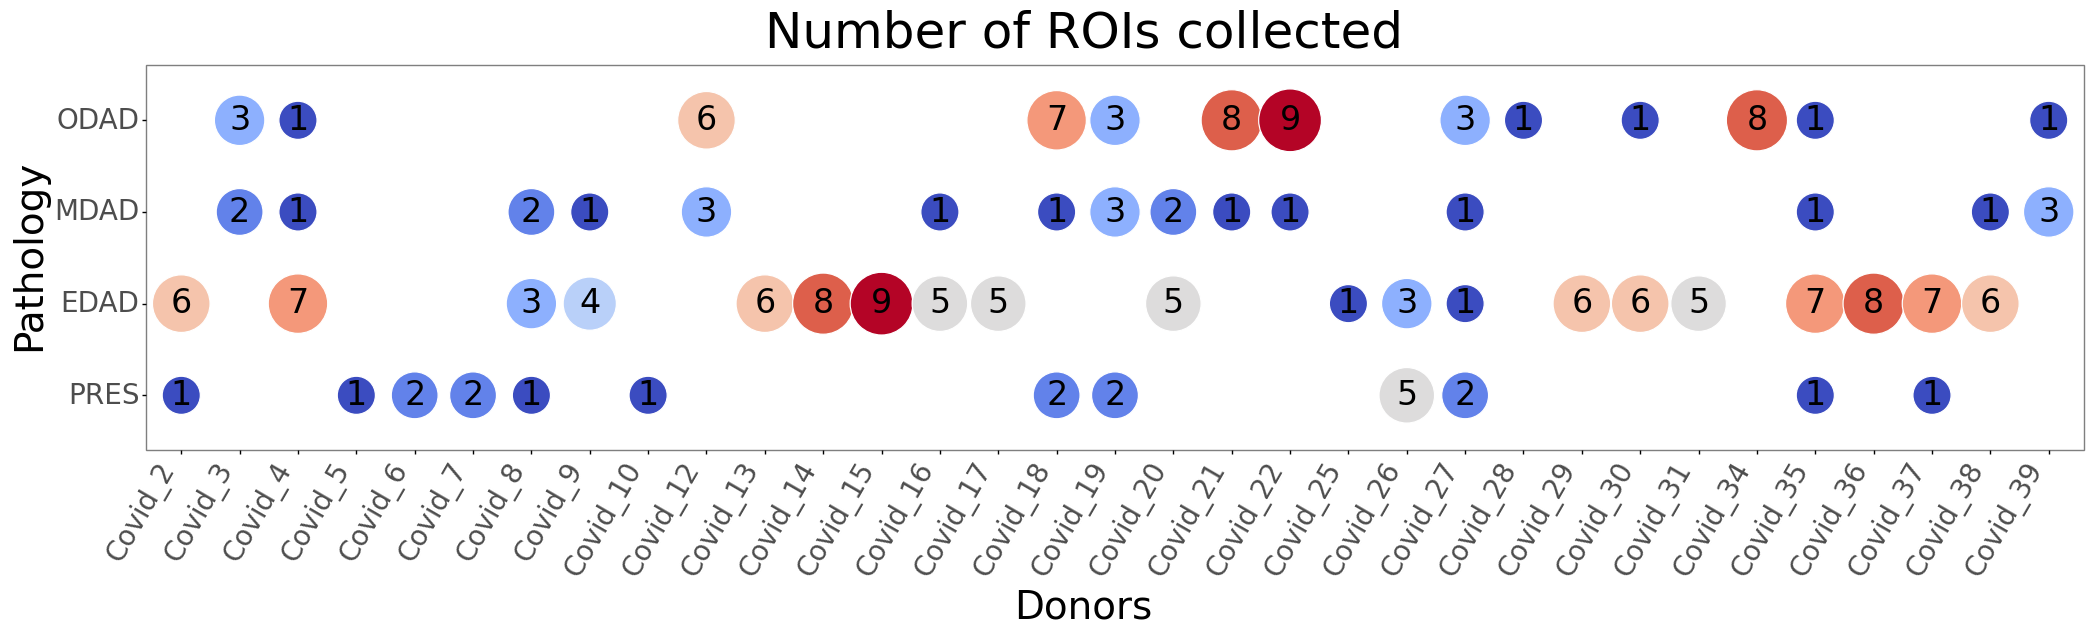

<ggplot: (8788844336597)>

In [5]:
plotnine.options.figure_size=(25,5)
plotnine.dpi = dpi

p1=(
    ggplot() +
    geom_point(data=cross, mapping=aes(x = "Donor_AltName", y = "Pathology", fill = "n_ROIs", size = "n_ROIs"), colour = "white")+ 
    geom_text(data=cross,mapping=aes(x = "Donor_AltName", y = "Pathology", label = "n_ROIs"), size=24)  + 
    theme_bw() +
    theme(axis_text_x = element_text(angle = 60, vjust = 1, hjust=1, size=20), 
          axis_text_y = element_text(size=20),
          title = element_text(size=36), 
          axis_title_x = element_text(size=28), 
          axis_title_y = element_text(size=28), 
          panel_grid_major_x = element_blank(),
          panel_grid_major_y = element_blank(),
          legend_position = "none" ) + 
    scale_size_continuous(range=[15,25]) +
    scale_y_discrete(limits=["PRES", "EDAD", "MDAD", "ODAD"]) +
    scale_x_discrete(limits = cross.Donor_AltName.unique()) +
    scale_fill_cmap(cmap_name="coolwarm" ) +
    xlab("Donors") + ylab("Pathology") + ggtitle("Number of ROIs collected")



)
p1

### Figure 3D

In [6]:
patho_candidates = pd.read_csv("../data/fig3_rf_top10_pathol_mean_exp.csv", sep = ",", index_col=0).columns
surface_candidates = pd.read_csv("../data/fig3_surface_rf_top10_pathol_mean_exp.csv", sep = ",", index_col=0).columns
secreted_candidates = pd.read_csv("../data/fig3_secreted_rf_top10_pathol_mean_exp.csv", sep = ",", index_col=0).columns
df_deg_EDADvsODAD =  pd.read_csv("../data/fig3_edger_EDAD_ODAD_deg.csv", sep = ",", index_col = 0)

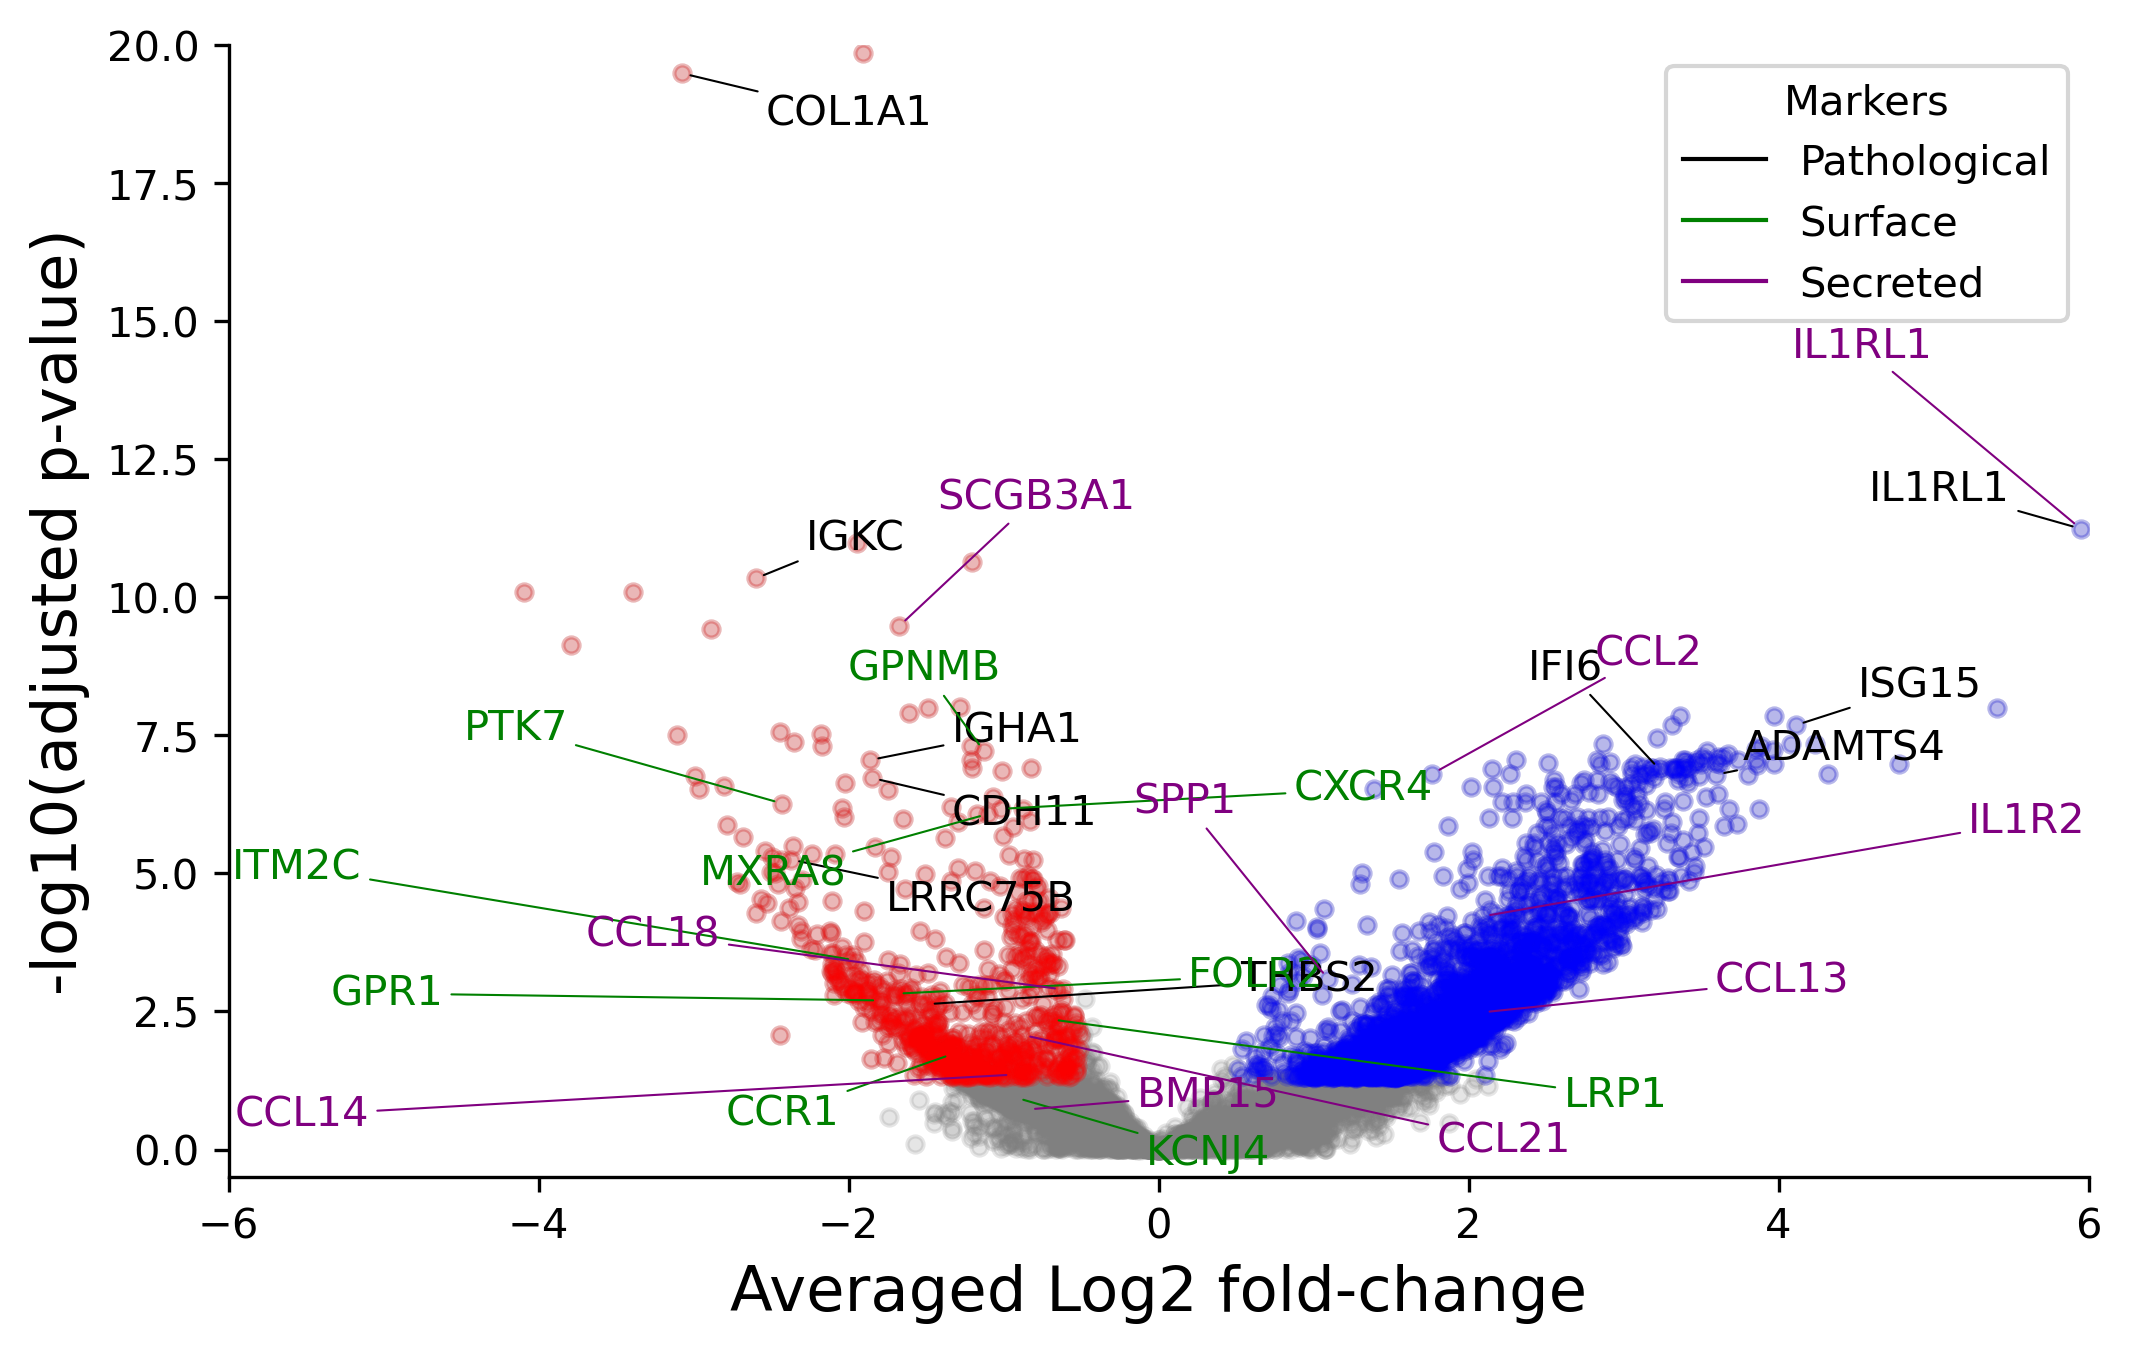

In [7]:
fdr = .05 
fc_thr = .5 
dotsize = 15
alpha = .2
xlim = [-6, 6]
ylim = [-.5,20]
title = ""
figsize = [8,5]
df_deg = df_deg_EDADvsODAD


df_i = df_deg[[df_deg.iloc[c].p_val_adj <= fdr and df_deg.iloc[c].avg_logFC >= fc_thr for c in range(len(df_deg)) ]]
df_d = df_deg[[df_deg.iloc[c].p_val_adj <= fdr and df_deg.iloc[c].avg_logFC <= -fc_thr for c in range(len(df_deg)) ]]

fig, ax = plt.subplots(figsize = tuple(figsize), dpi = dpi)
plt.rc('font', size = 10)          # controls default text sizes
plt.rc('axes', labelsize = 5)    # fontsize of the x and y labels
plt.rc('legend', fontsize = 5)    # legend fontsize
plt.rc('figure', titlesize = 5)  # fontsize of the figure title
ax.grid(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.scatter(df_deg.avg_logFC, -(np.log10(df_deg.p_val_adj)), s = dotsize, c='grey', alpha = alpha)
ax.scatter(df_d.avg_logFC, -(np.log10(df_d.p_val_adj)), s = dotsize, c='r', alpha = alpha)
ax.scatter(df_i.avg_logFC, -(np.log10(df_i.p_val_adj)), s = dotsize, c='b', alpha = alpha)
ax.set_xlabel('Averaged Log2 fold-change',size = 15)
ax.set_ylabel('-log10(adjusted p-value)', size = 15)
ax.set_title(title, size = 15)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

features = patho_candidates

df_text = df_deg[[df_deg.iloc[c].gene in features for c in range(len(df_deg))]]

texts_1 = [plt.text(x, y, s, color = "black") for x, y, s in zip(df_text.avg_logFC, -(np.log10(df_text.p_val_adj)), df_text.gene)]

adjust_text(texts_1, force_points=0.2, force_text=0.2,
            expand_points=(2, 2), expand_text=(2, 2),
            arrowprops=dict(arrowstyle="-", color='black', lw=0.5))

features = surface_candidates

df_text = df_deg[[df_deg.iloc[c].gene in features for c in range(len(df_deg))]]

texts_2 = [plt.text(x, y, s, color = "green") for x, y, s in zip(df_text.avg_logFC, -(np.log10(df_text.p_val_adj)), df_text.gene)]

adjust_text(texts_2, force_points=0.2, force_text=0.2,
            expand_points=(3, 3), expand_text=(3, 3),
            arrowprops=dict(arrowstyle="-", color='green', lw=0.5))

features = secreted_candidates

df_text = df_deg[[df_deg.iloc[c].gene in features for c in range(len(df_deg))]]

texts_3 = [plt.text(x, y, s, color = "purple") for x, y, s in zip(df_text.avg_logFC, -(np.log10(df_text.p_val_adj)), df_text.gene)]

adjust_text(texts_3, force_points=0.2, force_text=0.2,
            expand_points=(4, 6), expand_text=(4, 4),
            arrowprops=dict(arrowstyle="-", color='purple', lw=0.5))


custom_lines = [Line2D([0], [0], color="black", lw=1),
                Line2D([0], [0], color="green", lw=1),
                Line2D([0], [0], color="purple", lw=1)]

ax.legend(custom_lines, ['Pathological', 'Surface', 'Secreted'], title = "Markers", fontsize = 10 )

### Figure 3Db

In [8]:
gene_list_rf=pd.read_csv('/home/jovyan/projects/nanostring-covid/data/jae-won/pathology_markers_v2/random_forest_all_sample_var1000_importance.csv', sep=',', index_col=0)
gene_list_rf['gene']=gene_list_rf.index
gene_list_rf=gene_list_rf[gene_list_rf.gene != "BAGE5" ] # not availabe in sc/sn data
selected_top20_markers = gene_list_rf.iloc[0:19]

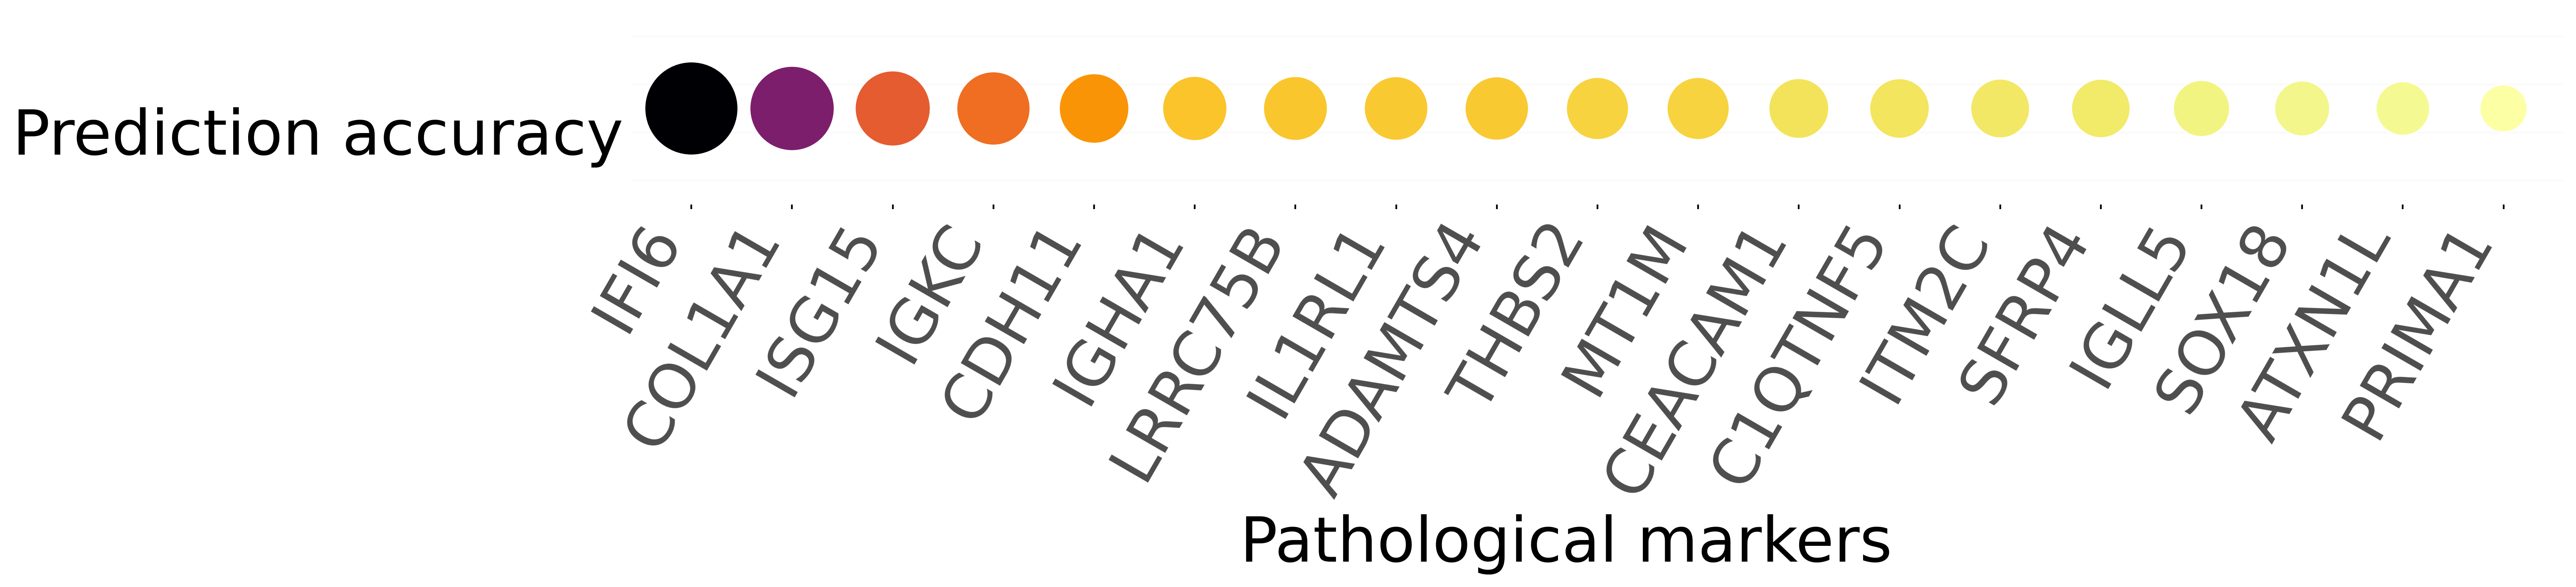

<ggplot: (8788834915577)>

In [9]:
plotnine.options.figure_size=(20,2)
plotnine.options.dpi = dpi

p1 = (
    ggplot() + 
    geom_point( data = selected_top20_markers, mapping = aes( x = "reorder(gene, -x)", y = "1", fill = "x", size = "x"), colour = "white") +
    theme_bw() +
    theme(axis_text_x = element_text(angle = 60, vjust = 1, hjust=1, size=36), 
          axis_text_y = element_blank(), 
          axis_title_y = element_text(angle = 0, vjust = 1, hjust = 1),
          title= element_text(size = 36),
          panel_grid_major_x = element_blank(),
          panel_grid_major_y = element_blank(),
          panel_border = element_blank(),
          axis_ticks_major_y = element_blank(),
          legend_position = "none" ) + 
    scale_size_continuous(range=[15,30]) +
    scale_fill_cmap(cmap_name = "inferno_r") +
    xlab("Pathological markers") + ylab("Prediction accuracy") 
)

p1

### Figure 3E

In [10]:
path = '/lustre/scratch117/cellgen/team283/tl7/project/nanostring-covid/data/20220202_WTA/'
sp_adata = sc.read_h5ad(f"{path}finalRun_geneProbeCounts_AnnData_CC-SimpleCorrected_Filtered_UKCIC-Lung_4Patho.h5ad")

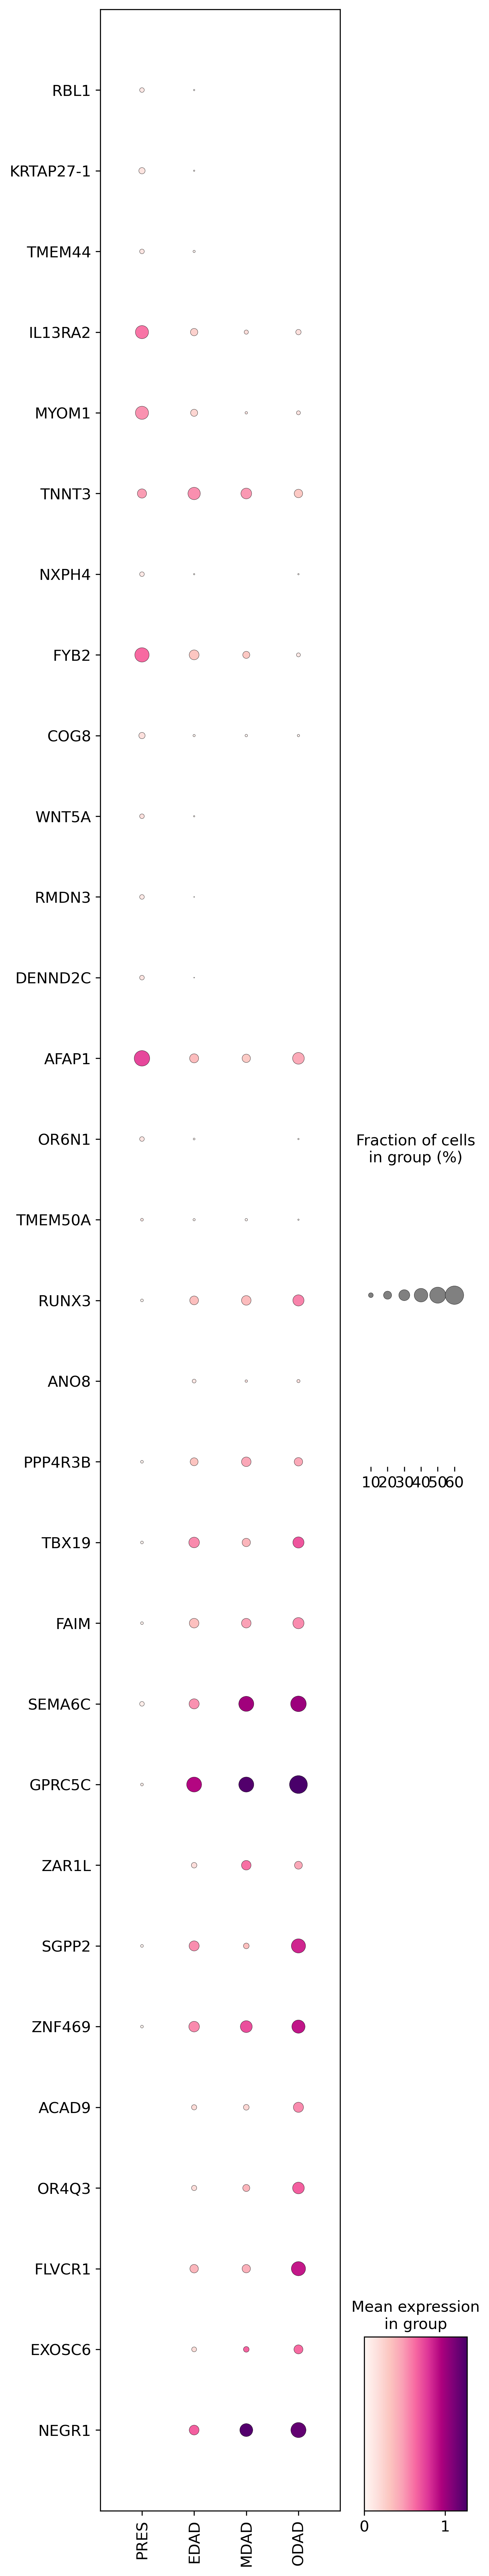

In [11]:
sc.set_figure_params(scanpy=True, fontsize=14, dpi = dpi) 

subset_features = [
    "RBL1", "KRTAP27-1", "TMEM44", "IL13RA2", "MYOM1", 
    "TNNT3", "NXPH4", "FYB2", "COG8", "WNT5A", 
    "RMDN3", "DENND2C", "AFAP1", "OR6N1", "TMEM50A", 
    "RUNX3", "ANO8", "PPP4R3B", "TBX19", "FAIM", 
    "SEMA6C", "GPRC5C", "ZAR1L", "SGPP2", "ZNF469", 
    "ACAD9", "OR4Q3", "FLVCR1", "EXOSC6", "NEGR1"
    
]
sc.pl.dotplot(adata=sp_adata, var_names = subset_features,
              groupby="Pathology", categories_order = ["PRES", "EDAD", "MDAD", "ODAD"], swap_axes=True,
              dendrogram=False, figsize=[5, 35], log = True, layer = "X_cc_corrected", 
              mean_only_expressed = False,
              cmap='RdPu')

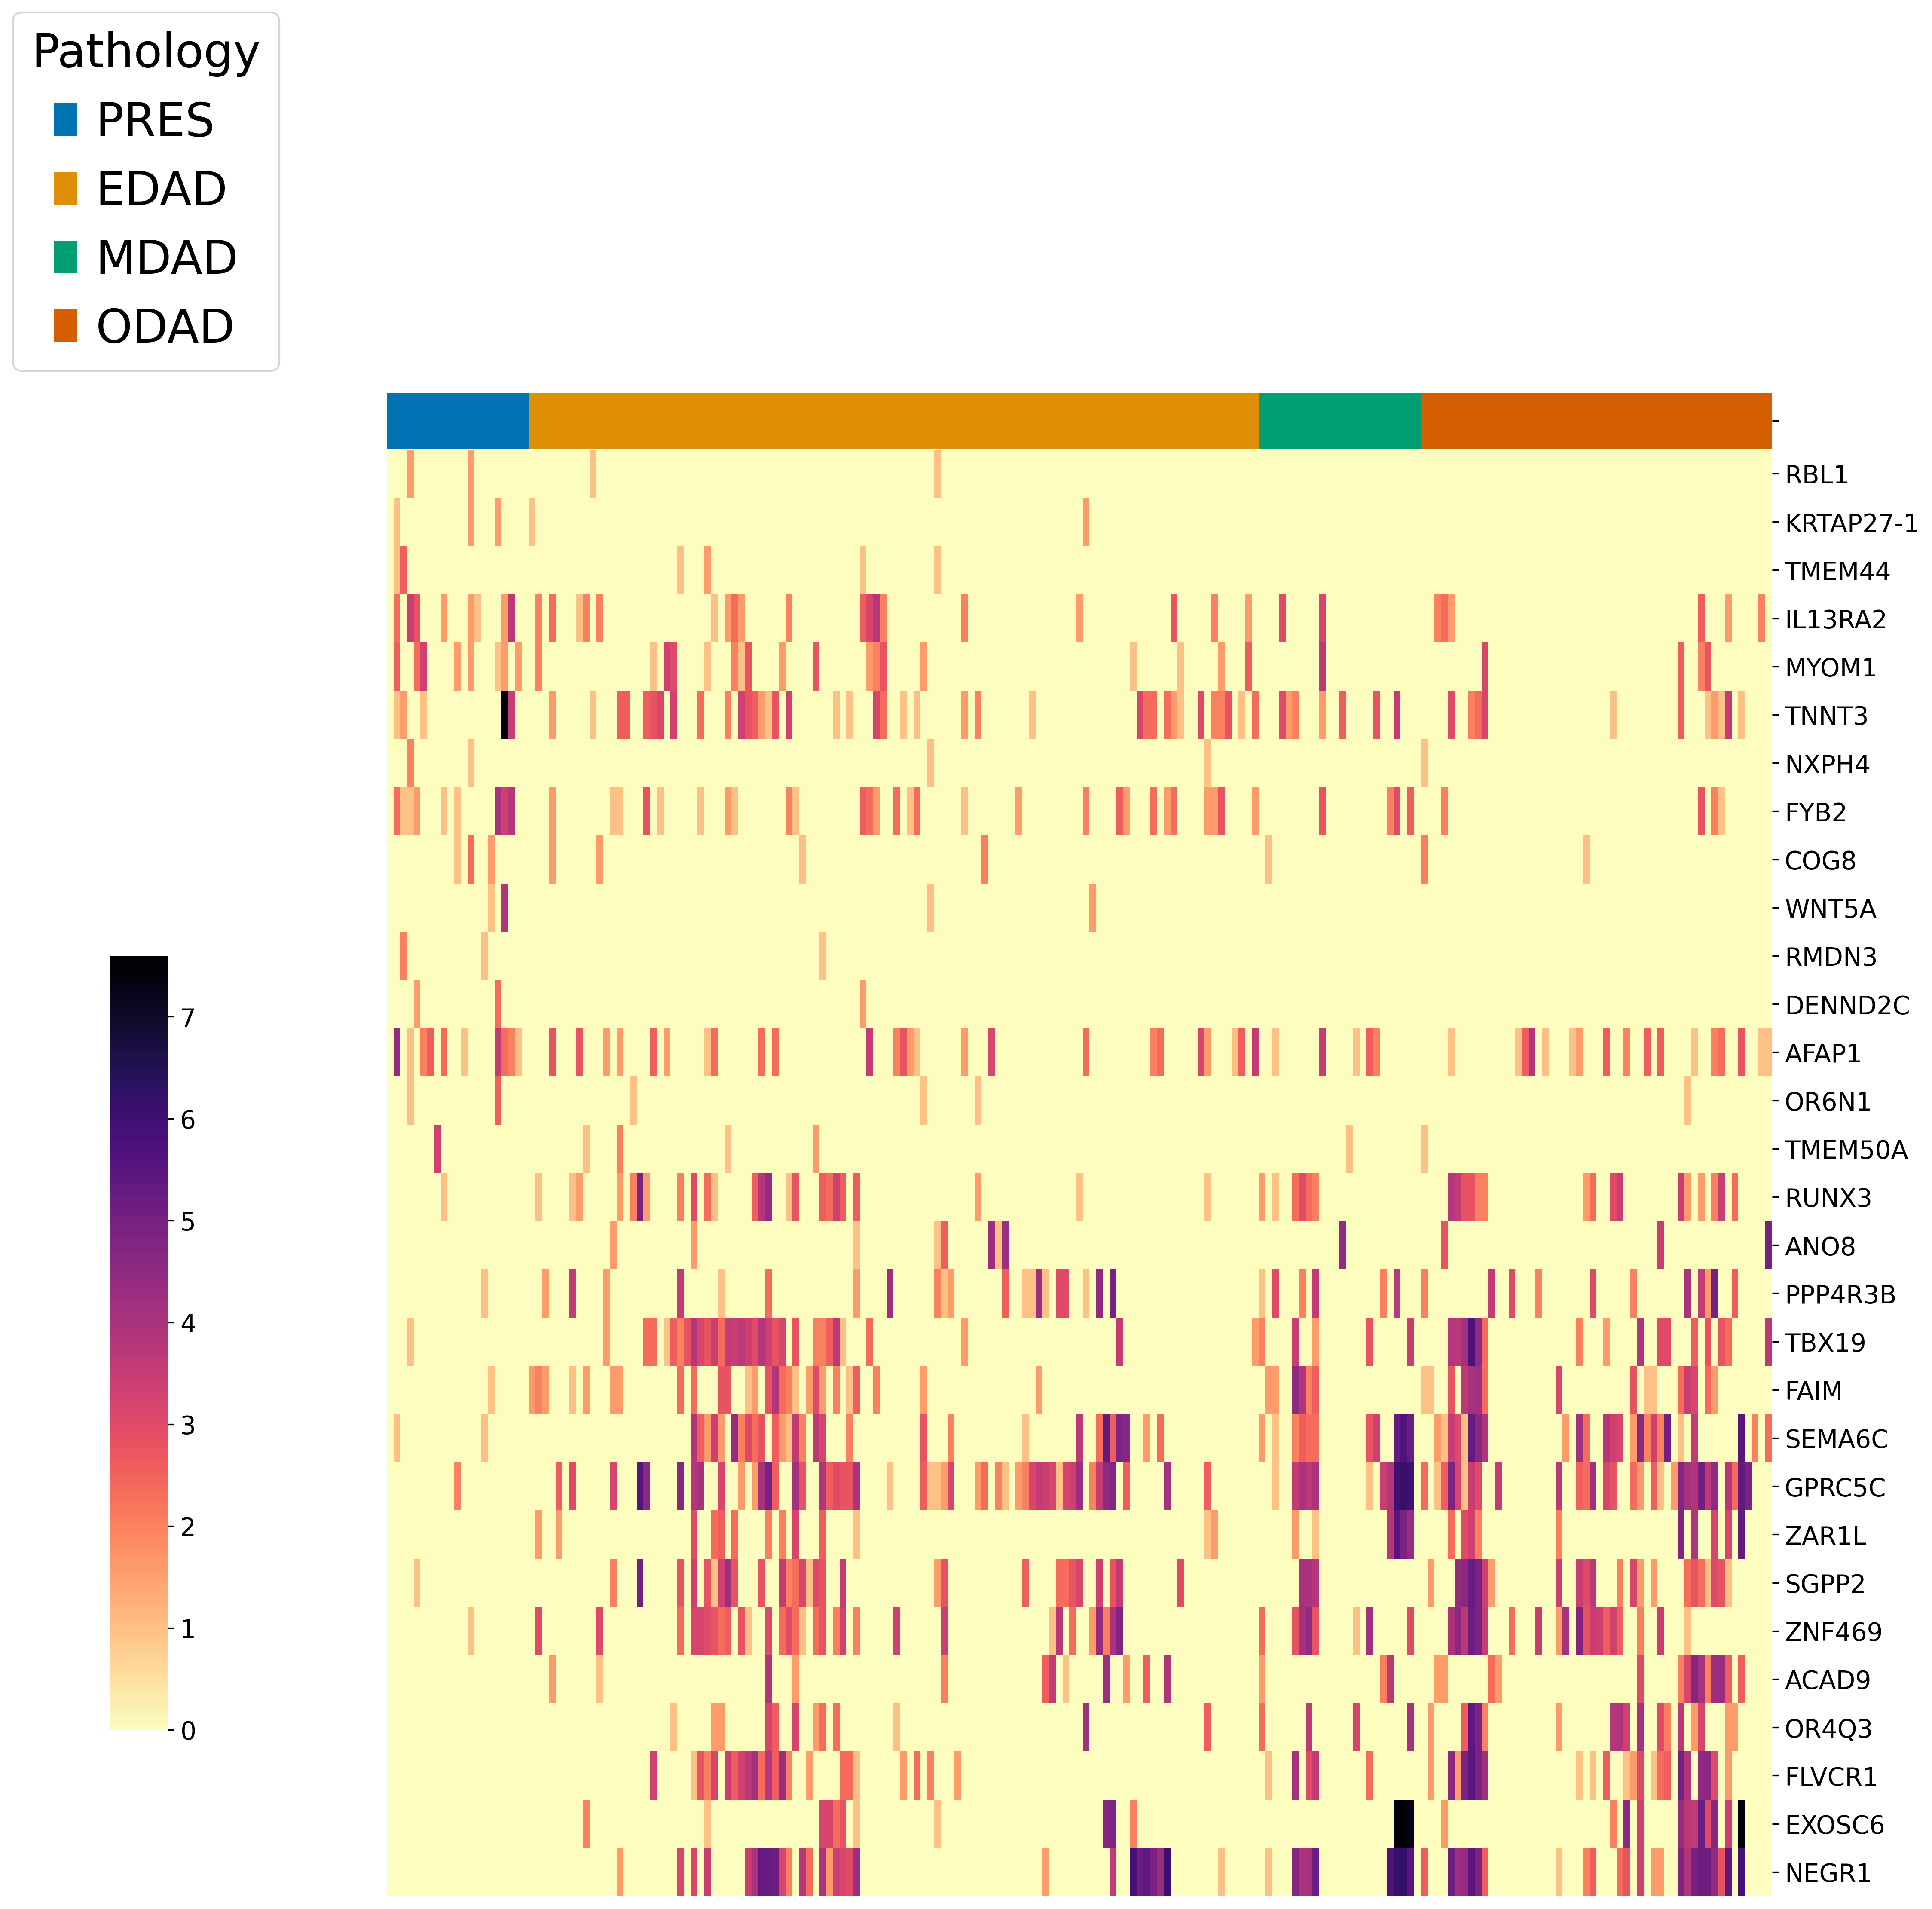

In [12]:
order_of_pathology = ['PRES', 'EDAD', 'MDAD', 'ODAD']

df_mx = pd.DataFrame(
    index = subset_features,
    data = sp_adata[flatten([sp_adata[[sp_adata.obs.iloc[c].Pathology in pathology for c in range(len(sp_adata))]].obs.index.to_list() for pathology in order_of_pathology]) ,
                   subset_features].layers["X_cc_corrected"].T
)

colours=sns.color_palette('colorblind', 4)
lut_clust = dict(zip(order_of_pathology, colours))

patho_codes = sp_adata[flatten([sp_adata[[sp_adata.obs.iloc[c].Pathology in pathology for c in range(len(sp_adata))]].obs.index.to_list() for pathology in order_of_pathology]) ,:].obs["Pathology"]
col_colors = [lut_clust.get(patho) for patho in patho_codes]
col_colors =pd.DataFrame(index = df_mx.columns.values, data = {"" : col_colors})

handles = [Patch(facecolor=lut_clust[name]) for name in lut_clust] # for adding legend

df_mx = df_mx.apply(lambda x: np.log2(x + 1) if np.issubdtype(x.dtype, np.number) else x)
ax = sns.clustermap(df_mx, 
                    figsize = [15,15], 
                    cmap='magma_r', 
                    row_cluster = False, 
                    col_cluster = False, 
                    col_colors=col_colors, xticklabels=False
                   )

ax.ax_cbar.set_position((0.05, 0.1, .03, .4))

plt.legend(handles, lut_clust, title = "Pathology",
           bbox_to_anchor=(0.15, 1), bbox_transform=plt.gcf().transFigure, fontsize = 26, title_fontsize = 26)